In [1]:
!git clone https://github.com/SiddharthMaverick/PCB_Defect_Classification_Deep_Learning.git

Cloning into 'pcb_defects_classification'...
remote: Enumerating objects: 14628, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 14628 (delta 3), reused 7 (delta 3), pack-reused 14616
Receiving objects: 100% (14628/14628), 95.24 MiB | 28.10 MiB/s, done.
Resolving deltas: 100% (4117/4117), done.
Updating files: 100% (14539/14539), done.


In [2]:
%cd pcb_defects_classification

/content/pcb_defects_classification


In [3]:
import os
from tools import config

if not os.path.exists(config.DEFECTS_PATH):
    !python "tools/extracted_defetcs.py"

In [4]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pickle
import glob
import cv2
from tensorflow.keras.applications import EfficientNetB0 # Change import
from tensorflow.keras.layers import Flatten, Dropout, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pickle
import glob
import cv2
import itertools


In [5]:
datagenAug = ImageDataGenerator(
    rotation_range=90,
	zoom_range=0.15,
	horizontal_flip=True,
	vertical_flip=True,
	validation_split=0.2
)

In [6]:
trainGen = datagenAug.flow_from_directory(
    config.DEFECTS_PATH, classes=config.CLASSES,
    target_size=(224, 224), class_mode="categorical",
    batch_size=32, subset="training")

testGen = datagenAug.flow_from_directory(
    config.DEFECTS_PATH, classes=config.CLASSES,
    target_size=(224, 224), class_mode="categorical",
    batch_size=32, subset="validation")

Found 8012 images belonging to 6 classes.
Found 2001 images belonging to 6 classes.


In [7]:
# Load EfficientNetB0 model
efficientnet_model = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

for layer in efficientnet_model.layers[:-1]:
    layer.trainable = False

head = efficientnet_model.output
flatten = Flatten()(head)
fc = Dense(512, activation='relu')(flatten)
output = Dense(len(trainGen.class_indices), activation="softmax")(fc)

model = Model(inputs=efficientnet_model.input, outputs=output)

16705208/16705208 [==============================] - 0s 0us/step


In [8]:
opt = Adam(learning_rate=1e-4)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

In [9]:
#checkpoint = ModelCheckpoint(os.path.sep.join([config.OUTPUT_PATH, "vgg.h5"]), monitor='accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq=1)
checkpoint = ModelCheckpoint(os.path.sep.join([config.OUTPUT_PATH, "efficient.keras"]), monitor='accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq=1)

early = EarlyStopping(monitor='accuracy', min_delta=0, patience=100, verbose=1, mode='auto')

In [10]:
hist = model.fit(
    trainGen, steps_per_epoch=trainGen.samples // 32,
	validation_data=testGen, validation_steps=testGen.samples // 32,
	epochs=15, callbacks=[checkpoint, early])

model.save(os.path.sep.join([config.OUTPUT_PATH, "efficient.model"]), save_format='h5')

Streaming output truncated to the last 5000 lines.
 10/250 [>.............................] - ETA: 1:13 - loss: 0.0840 - accuracy: 0.9719
Epoch 6: accuracy did not improve from 1.00000
 11/250 [>.............................] - ETA: 1:15 - loss: 0.0772 - accuracy: 0.9744
Epoch 6: accuracy did not improve from 1.00000
 12/250 [>.............................] - ETA: 1:16 - loss: 0.0991 - accuracy: 0.9714
Epoch 6: accuracy did not improve from 1.00000
 13/250 [>.............................] - ETA: 1:17 - loss: 0.1062 - accuracy: 0.9712
Epoch 6: accuracy did not improve from 1.00000
 14/250 [>.............................] - ETA: 1:17 - loss: 0.1136 - accuracy: 0.9710
Epoch 6: accuracy did not improve from 1.00000
 15/250 [>.............................] - ETA: 1:18 - loss: 0.1103 - accuracy: 0.9708
Epoch 6: accuracy did not improve from 1.00000
 16/250 [>.............................] - ETA: 1:18 - loss: 0.1166 - accuracy: 0.9707
Epoch 6: accuracy did not improve from 1.00000
 17/250 [=>

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


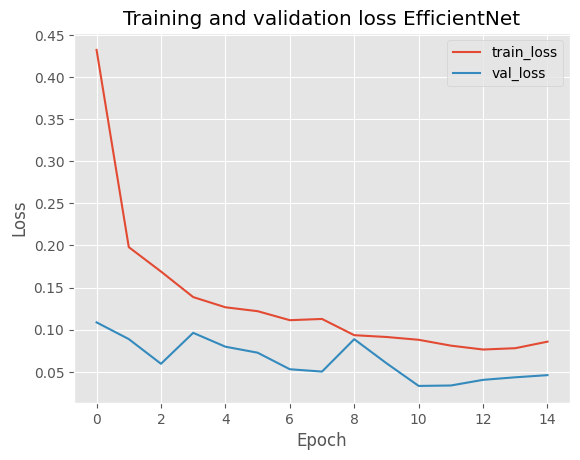

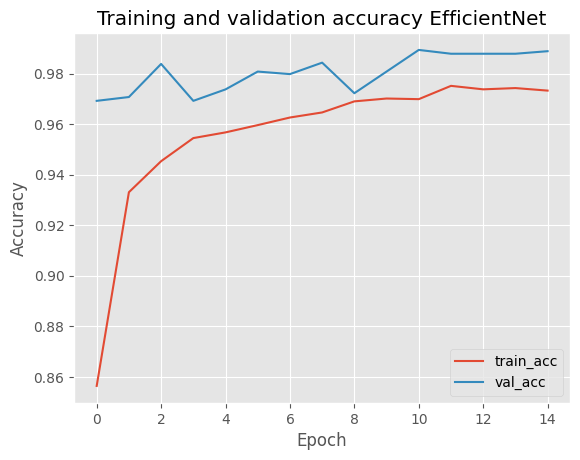

In [11]:
N = np.arange(0, 15)

plt.style.use("ggplot")
plt.figure()
plt.plot(N, hist.history["loss"], label="train_loss")
plt.plot(N, hist.history["val_loss"], label="val_loss")
plt.title("Training and validation loss EfficientNet")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig(os.path.sep.join([config.OUTPUT_PATH, "efficientnet_losses.png"]))
plt.legend()

plt.figure()
plt.plot(N, hist.history["accuracy"], label="train_acc")
plt.plot(N, hist.history["val_accuracy"], label="val_acc")
plt.title("Training and validation accuracy EfficientNet")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.savefig(os.path.sep.join([config.OUTPUT_PATH, "efficientnet_accuracy.png"]))
plt.legend()

plt.show()

1/1 [==============================] - 0s 23ms/step
              precision    recall  f1-score   support

        open      0.977     0.966     0.972       388
       short      0.980     0.953     0.966       301
    mousebit      0.979     0.936     0.957       393
        spur      0.929     0.972     0.950       325
      copper      0.961     1.000     0.980       294
    pin-hole      0.980     0.987     0.983       300

    accuracy                          0.968      2001
   macro avg      0.968     0.969     0.968      2001
weighted avg      0.968     0.968     0.967      2001



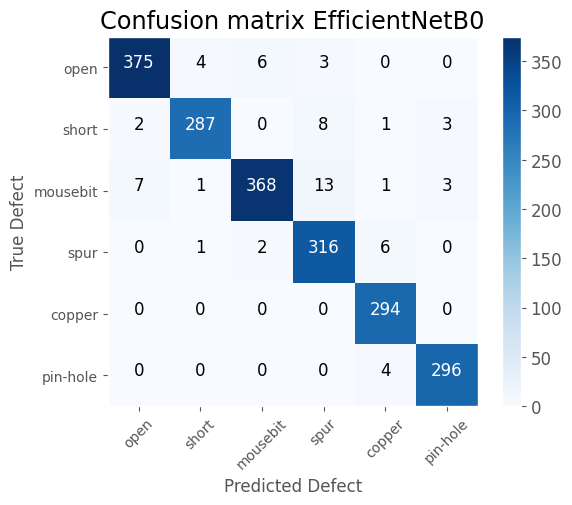

In [12]:
predictions = list()
for path in testGen.filepaths:
    image = cv2.imread(path)
    image = cv2.resize(image, (224, 224))
    image = np.expand_dims(image, axis=0)
    preds = model.predict(image)
    predictions.append(preds.argmax(axis=1))

print(classification_report(testGen.classes,
                            predictions, target_names=testGen.class_indices, digits=3))

plt.style.use("ggplot")
plt.grid(False)
plt.rcParams["figure.figsize"] = (8,6)
font = {'size' : 12}
plt.rc('font', **font)

cm = confusion_matrix(testGen.classes, predictions)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(testGen.class_indices))

plt.xticks(tick_marks, testGen.class_indices, rotation=45)
plt.yticks(tick_marks, testGen.class_indices)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.xlabel('Predicted Defect')
plt.ylabel('True Defect')
plt.title('Confusion matrix EfficientNetB0') # Change title
plt.savefig('output/efficientnet_confusion_matrix.png') # Change file name
plt.show()